# Hybrid Filter for Image Enhancement

This Jupyter Notebook implements a hybrid filter for image enhancement, as described in the paper *A Hybrid Filter for Image Enhancement* by Shaomin Peng and Lori Lucke. The filter removes mixed Gaussian and impulsive noise from color images while preserving details.

## Filter Description
- **Step 1: Selective Peeling**: Removes impulsive noise (e.g., salt-and-pepper) by replacing pixels that deviate significantly from the median in a local window with the median value.
- **Step 2: Fuzzy Weighted Averaging**: Smooths Gaussian noise using a weighted average, with weights determined by a Gaussian-like fuzzy membership function based on pixel intensity differences.

## Usage
- **Prerequisites**:
  - Install Jupyter Notebook: `pip install jupyter`
  - Install dependencies: `pip install numpy matplotlib pillow ipywidgets`
  - Enable widgets: `jupyter nbextension enable --py widgetsnbextension`
  - For JupyterLab: `jupyter labextension install @jupyter-widgets/jupyterlab-manager`

- **Notes**:
  - If RGB histograms are identical (e.g., due to a grayscale image), Cell 8 will show high correlations (~1). Use Cell 5’s synthetic image or upload a colorful image.
  - The filter processes RGB channels separately to preserve color and does not use training data.
  - For best results, use images with mixed Gaussian and impulsive noise.

In [1]:
# Cell 2: Install Dependencies
# Purpose: Ensures required packages are installed (uncomment to run if needed).
# !pip install numpy matplotlib pillow ipywidgets

# Import Libraries
##### Purpose: Imports libraries for array operations, plotting, image handling, and interactive widgets.

In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import ipywidgets as widgets
import torch
from IPython.display import display, clear_output
import torch.nn.functional as F
import time
%matplotlib inline
import cv2
import scipy.ndimage as ndimage
from tabulate import tabulate
from scipy.ndimage import median_filter as scipy_median_filter
from skimage.metrics import mean_squared_error,  peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_absolute_error

# Define Hybrid Filter Function
##### Purpose: Implements the hybrid filter to remove mixed Gaussian and impulsive noise from color images.
- Step 1: Selective Peeling (removes impulsive noise using median replacement).
- Step 2: Fuzzy Weighted Averaging (smooths Gaussian noise with Gaussian-like weights).
- Processes RGB channels separately to preserve color.
- Optionally returns the peeled image for visualization.

In [67]:
def hybrid_filter(image, window_size=3, threshold=50, sigma=30, return_peeled=False):
    """
    Apply the hybrid filter to remove mixed Gaussian and impulsive noise on a grayscale image.
    
    Parameters:
    - image: Input noisy image (H x W numpy array, grayscale).
    - window_size: Size of the local neighborhood (3, 5, or 7).
    - threshold: Threshold for detecting impulsive noise.
    - sigma: Parameter for the Gaussian-like fuzzy weight function.
    - return_peeled: If True, return the peeled image (after Step 1).
    
    Returns:
    - filtered_image: Filtered image (H x W numpy array).
    - peeled_image: Peeled image (H x W numpy array, optional).
    """
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale (H x W).")
    
    if window_size % 2 == 0:
        window_size += 1
    N = window_size // 2
    
    height, width = image.shape
    peeled_image = np.copy(image).astype(np.float64)
    filtered_image = np.zeros_like(image, dtype=np.float64)
    
    # Step 1: Selective Peeling
    for y in range(N, height - N):
        for x in range(N, width - N):
            window = image[y-N:y+N+1, x-N:x+N+1]
            median_val = np.median(window)
            center_val = image[y, x]
            if abs(center_val - median_val) > threshold:
                peeled_image[y, x] = median_val
    
    # Step 2: Fuzzy Weighted Averaging
    for y in range(N, height - N):
        for x in range(N, width - N):
            window = peeled_image[y-N:y+N+1, x-N:x+N+1]
            center_val = peeled_image[y, x]
            weights = np.zeros((window_size, window_size))
            for j in range(window_size):
                for i in range(window_size):
                    delta = abs(center_val - window[j, i])
                    weights[j, i] = np.exp(-delta**2 / (2 * sigma**2))
            weighted_sum = np.sum(weights * window)
            weight_total = np.sum(weights)
            filtered_image[y, x] = weighted_sum / weight_total if weight_total > 0 else center_val
    
    # Handle borders
    filtered_image[:N, :] = peeled_image[:N, :]
    filtered_image[-N:, :] = peeled_image[-N:, :]
    filtered_image[:, :N] = peeled_image[:, :N]
    filtered_image[:, -N:] = peeled_image[:, -N:]
    
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
    if return_peeled:
        peeled_image = np.clip(peeled_image, 0, 255).astype(np.uint8)
        return filtered_image, peeled_image
    return filtered_image

# Create Interactive Interface
##### Purpose: Sets up widgets for uploading an image and specifying filter parameters.
- Stores image and parameters in global variables.


In [ ]:
# Global variables
global_image = None  # Reset to allow synthetic image or upload
global_window_size = 3
global_threshold = 50
global_sigma = 30

def create_interactive_filter():
    upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Image')
    window_size = widgets.Dropdown(options=[3, 5, 7], value=3, description='Window Size:')
    threshold = widgets.IntSlider(min=10, max=100, value=50, description='Threshold:')
    sigma = widgets.IntSlider(min=10, max=100, value=30, description='Sigma:')
    apply_button = widgets.Button(description='Apply Filter', button_style='primary')
    output = widgets.Output()
    
    display(widgets.VBox([upload, window_size, threshold, sigma, apply_button, output]))
    
    def on_apply_button_clicked(b):
        with output:
            clear_output()
            if not upload.value:
                print('Please upload an image first!')
                return
            uploaded_file = upload.value[0]
            image = Image.open(io.BytesIO(uploaded_file['content']))
            image = np.array(image)
            global global_image, global_window_size, global_threshold, global_sigma
            global_image = image
            global_window_size = window_size.value
            global_threshold = threshold.value
            global_sigma = sigma.value
            print('Image uploaded. Run the next cells to apply the filter.')
    
    apply_button.on_click(on_apply_button_clicked)

create_interactive_filter()

# Apply Filter and Display Images
##### Purpose: Applies the hybrid filter using the uploaded or synthetic image and parameters.
- Displays original, peeled, and filtered images in a 1x3 subplot.

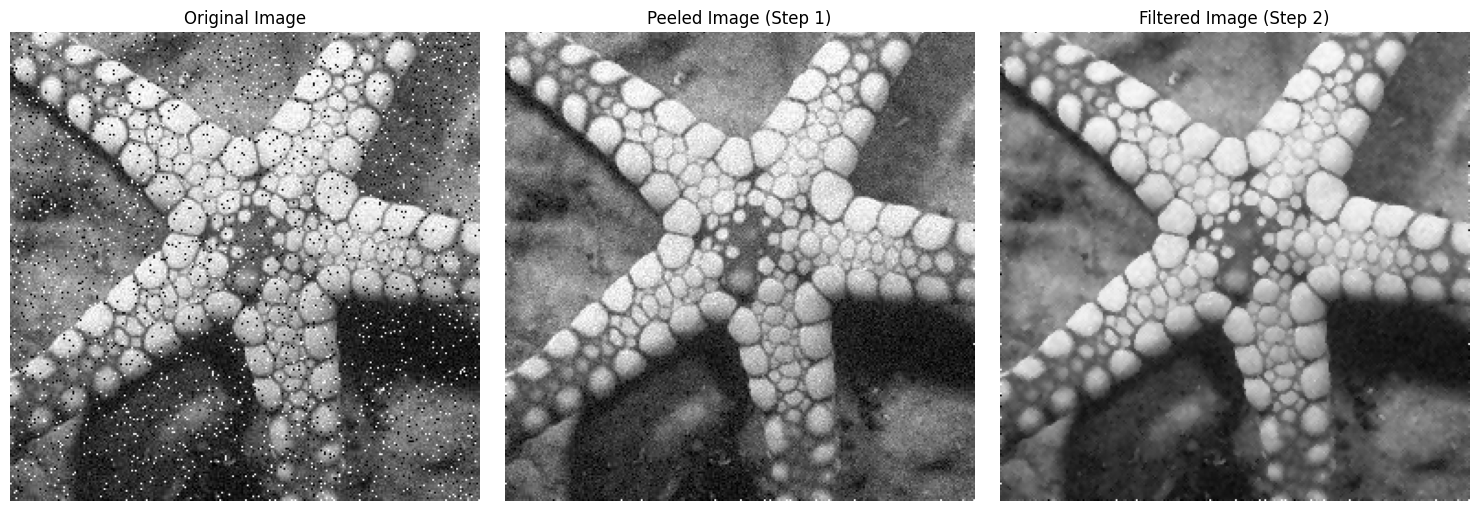

In [69]:
if global_image is None:
    print('Please run Cell 5 to generate a synthetic image or Cell 6 to upload an image first!')
else:
    filtered_image, peeled_image = hybrid_filter(
        global_image, global_window_size, global_threshold, global_sigma, return_peeled=True
    )
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(global_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(peeled_image, cmap='gray')
    plt.title('Peeled Image (Step 1)')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image (Step 2)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize Histograms and Difference Image
##### Purpose: Analyzes the filter's effect using histograms and a difference image.
- Histograms: Plots RGB channel intensities for original and filtered images.
- Difference Image: Shows |original - filtered| to highlight noise removal.


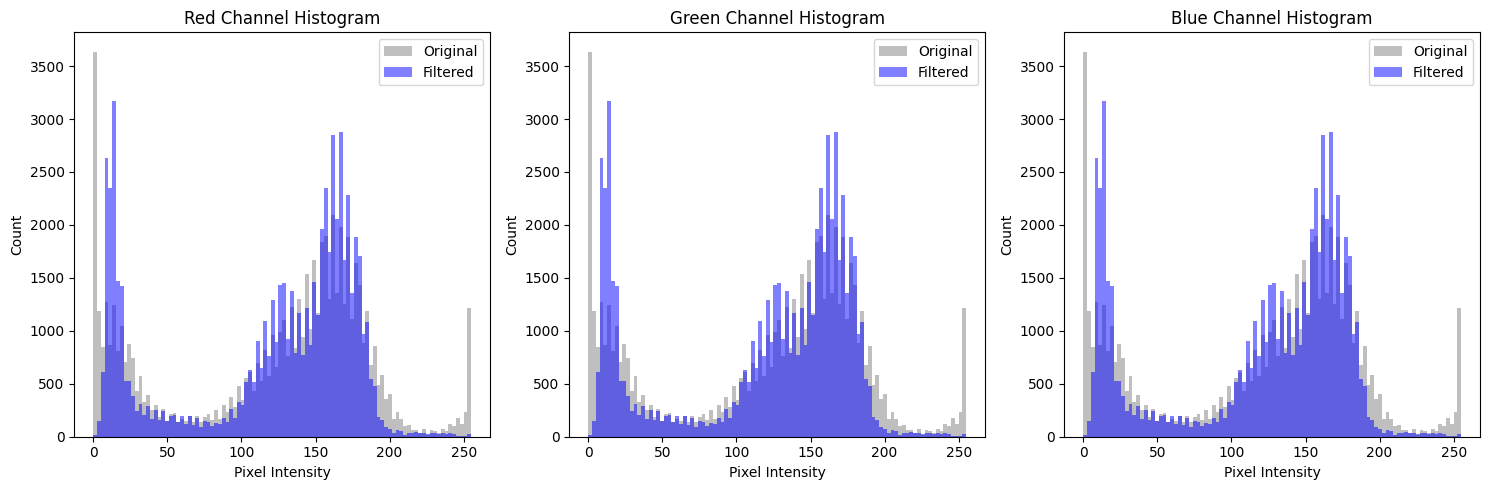

In [7]:

if global_image is None or 'filtered_image' not in locals():
    print('Please run the previous cells to generate or upload an image and apply the filter first!')
else:
    plt.figure(figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']
    for i, color in enumerate(colors):
        plt.subplot(1, 3, i+1)
        plt.hist(global_image[:, :, i].ravel(), bins=100, color='gray', alpha=0.5, label='Original', density=False)
        plt.hist(filtered_image[:, :, i].ravel(), bins=100, color='blue', alpha=0.5, label='Filtered', density=False)
        plt.title(f'{color} Channel Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
if global_image is None or 'filtered_image' not in locals():
    print('Please run the previous cells to generate or upload an image and apply the filter first!')
else:
    plt.figure(figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']
    diff_image = np.abs(global_image.astype(np.float64) - filtered_image.astype(np.float64))
    diff_image = np.mean(diff_image, axis=2)
    plt.figure(figsize=(6, 5))
    plt.imshow(diff_image, cmap='hot')
    plt.colorbar(label='Intensity Difference')
    plt.title('Difference Image (Original - Filtered)')
    plt.axis('off')
    plt.show()

Please run the previous cells to generate or upload an image and apply the filter first!


# Optimize σ Using LMS
##### Purpose: Learn the optimal parameter σ for the fuzzy Gaussian weighting function using the Least Mean Square (LMS) algorithm.
- **Membership Function**: Uses Gaussian function $ w(\Delta x') = \exp\left(-\frac{(\Delta x')^2}{2\sigma^2}\right) $ to assign weights.
- **Training Data**: Each 3×3 window from the image is used to compute weights and compare with desired values.
- **LMS Update Rule**: σ is adjusted iteratively to minimize the total squared error between the computed and desired memberships.

### Training Steps:
1. Extract 3×3 windows from a training image (original or filtered).
2. Compute $ \Delta x_{i,j}' = x_{i,j}' - x_{m,n}' $ for each pixel in the window.
3. Calculate fuzzy membership values for each neighbor using current σ.
4. Compare with desired membership labels (1 for clean pixels, 0 for noisy).
5. Compute error $ e_{i,j} = d_{i,j} - w(\Delta x_{i,j}') $.
6. Compute gradient of error with respect to σ.
7. Update σ: $ \sigma \leftarrow \sigma - \eta \cdot \frac{\partial E}{\partial \sigma} $

In [20]:
# Global variables
global_original_image = None
global_noisy_image = None
global_window_size = 3
global_threshold = 50
global_sigma = 30

def create_interactive_upload():
    upload_original = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Original Image')
    upload_noisy = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Noisy Image')
    window_size = widgets.Dropdown(options=[3, 5, 7], value=3, description='Window Size:')
    threshold = widgets.IntSlider(min=10, max=100, value=50, description='Threshold:')
    sigma = widgets.IntSlider(min=10, max=100, value=30, description='Sigma:')
    apply_button = widgets.Button(description='Apply Filter', button_style='primary')
    output = widgets.Output()
    
    display(widgets.VBox([upload_original, upload_noisy, window_size, threshold, sigma, apply_button, output]))
    
    def on_apply_button_clicked(b):
        with output:
            clear_output()
            if not upload_original.value or not upload_noisy.value:
                print('Please upload both original and noisy images!')
                return
            original_file = upload_original.value[0]
            noisy_file = upload_noisy.value[0]
            original_image = Image.open(io.BytesIO(original_file['content']))
            noisy_image = Image.open(io.BytesIO(noisy_file['content']))
            original_image = np.array(original_image.convert('RGB'))
            noisy_image = np.array(noisy_image.convert('RGB'))
            global global_original_image, global_noisy_image, global_window_size, global_threshold, global_sigma
            global_original_image = original_image
            global_noisy_image = noisy_image
            global_window_size = window_size.value
            global_threshold = threshold.value
            global_sigma = sigma.value
            print('Images uploaded. Run the next cells to apply the filter or optimize sigma.')
    
    apply_button.on_click(on_apply_button_clicked)

create_interactive_upload()

In [21]:
def hybrid_filter_pytorch(noisy_image, window_size=3, threshold=50, sigma=30):
    """
    Apply the hybrid filter to remove mixed Gaussian and impulsive noise using PyTorch.
    
    Parameters:
    - noisy_image: Input noisy image (torch tensor, H x W x 3).
    - window_size: Size of the local neighborhood (3, 5, or 7).
    - threshold: Threshold for detecting impulsive noise.
    - sigma: Parameter for the Gaussian-like fuzzy weight function (torch tensor).
    
    Returns:
    - filtered_image: Filtered image (torch tensor, H x W x 3).
    """
    if window_size % 2 == 0:
        window_size += 1
    N = window_size // 2
    
    height, width, channels = noisy_image.shape
    peeled_image = noisy_image.clone().to(dtype=torch.float32)
    
    # Step 1: Selective Peeling
  
    padded_image = F.pad(peeled_image.permute(2, 0, 1), (N, N, N, N), mode='reflect')  # Shape: (C, H+2N, W+2N)
    
    # Extract all windows using unfold
    unfolded = padded_image.unsqueeze(0)  # Shape: (1, C, H+2N, W+2N)
    patches = F.unfold(unfolded, kernel_size=window_size, stride=1)  # Shape: (1, C*window_size*window_size, num_patches)
    num_patches = (height) * (width)
    patches = patches.view(channels, window_size * window_size, num_patches)  # Shape: (C, window_size*window_size, num_patches)
    
    # Compute median for each window
    median_vals = torch.median(patches, dim=1)[0]  # Shape: (C, num_patches)
    median_vals = median_vals.view(channels, height, width).permute(1, 2, 0)  # Shape: (H, W, C)
    
    # Get center values (original pixel values at the center of each window)
    center_vals = noisy_image  # Shape: (H, W, C)
    
    # Detect impulsive noise and replace with median
    mask_impulsive = torch.abs(center_vals - median_vals) > threshold  # Shape: (H, W, C)
    peeled_image = torch.where(mask_impulsive, median_vals, peeled_image)
    
    # Step 2: Fuzzy Weighted Averaging (vectorized)
    # Add padding to handle borders
   
    peeled_image_batched = peeled_image.unsqueeze(0)
    padded_peeled = F.pad(peeled_image_batched, (0,0,N,N,N,N), mode='reflect')  # Shape: (H+2N, W+2N, C)
    padded_peeled = padded_peeled.squeeze(0)
  
    padded_height, padded_width, actual_channels = padded_peeled.shape
  
    # Extract all windows using unfold
    unfolded = padded_peeled.permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H+2N, W+2N)
    patches = F.unfold(unfolded, kernel_size=window_size, stride=1)  # Shape: (1, C*window_size*window_size, num_patches)
    num_patches = (padded_height - window_size + 1) * (padded_width - window_size + 1)
  
    patches = patches.view(channels, window_size * window_size, num_patches)  # Shape: (C, window_size*window_size, num_patches)
    
    # Get center values for each window
    center_vals = patches[:, (window_size * window_size) // 2, :]  # Shape: (C, num_patches)
    center_vals = center_vals.view(channels, 1, num_patches)  # Shape: (C, 1, num_patches)
    
    # Compute deltas and weights
    deltas = torch.abs(patches - center_vals)  # Shape: (C, window_size*window_size, num_patches)
    weights = torch.exp(-deltas**2 / (2 * sigma**2))  # Shape: (C, window_size*window_size, num_patches)
    
    # Compute weighted sum and total weight
    weighted_sum = torch.sum(weights * patches, dim=1)  # Shape: (C, num_patches)
    weight_total = torch.sum(weights, dim=1)  # Shape: (C, num_patches)
    
    # Compute filtered values
    filtered_vals = weighted_sum / (weight_total + 1e-6)  # Shape: (C, num_patches)
    filtered_vals = filtered_vals.view(channels, padded_height - window_size +1, padded_width- window_size +1)  # Shape: (C, H, W)
    filtered_vals = filtered_vals.permute(1, 2, 0)  # Shape: (H, W, C)



    # Đảm bảo kích thước chính xác
    filtered_image = filtered_vals  # Shape: (256, 256, C)

    # Handle cases where weight_total is 0
    mask_zero_weight = (weight_total == 0).view(channels, padded_height - window_size + 1, padded_width - window_size + 1).permute(1, 2, 0)  # Shape: (254, 256, C)
    # mask_zero_weight = F.pad(mask_zero_weight, (0, 0, N, N,N,N), mode='constant', value=0)  # Shape: (256, 256, C)
    # mask_zero_weight = mask_zero_weight[:height, :width, :]  # Shape: (256, 256, C)
    filtered_image = torch.where(mask_zero_weight, peeled_image, filtered_image)
    
   
    # Handle borders
    filtered_image[:N, :, :] = peeled_image[:N, :, :]
    filtered_image[-N:, :, :] = peeled_image[-N:, :, :]
    filtered_image[:, :N, :] = peeled_image[:, :N, :]
    filtered_image[:, -N:, :] = peeled_image[:, -N:, :]
    
    filtered_image = torch.clamp(filtered_image, 0, 255)
    return filtered_image

def optimize_sigma_lms(original_image, noisy_image, initial_sigma=16, learning_rate=0.01, max_iterations=500, window_size=3):
    """
    Optimize the sigma parameter for the fuzzy Gaussian weighting function using LMS with PyTorch.
    
    Parameters:
    - original_image: Original clean image (H x W x 3 numpy array, RGB).
    - noisy_image: Noisy input image (H x W x 3 numpy array, RGB).
    - initial_sigma: Initial value for sigma.
    - learning_rate: Step size for gradient descent.
    - max_iterations: Maximum number of iterations for LMS.
    - window_size: Size of the local neighborhood (default 3).
    
    Returns:
    - optimal_sigma: Optimized sigma value.
    """
    # Convert numpy arrays to PyTorch tensors
    original_tensor = torch.tensor(original_image, dtype=torch.float32)
    noisy_tensor = torch.tensor(noisy_image, dtype=torch.float32)

    
    # Define sigma as a learnable parameter
    sigma = torch.nn.Parameter(torch.tensor(float(initial_sigma), dtype=torch.float32))

    
    optimizer = torch.optim.AdamW([sigma], lr=learning_rate)
    
    for iteration in range(max_iterations):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Apply hybrid filter to get s_{i,j} (filtered_image)
        filtered_image = hybrid_filter_pytorch(noisy_tensor, window_size=3, threshold=50, sigma=sigma)
        
        # Calculate MSE between original_image (x_{i,j}) and filtered_image (s_{i,j})
        mse = torch.mean((original_tensor - filtered_image)**2)
        
        # Compute gradients and update sigma
        mse.backward()
        optimizer.step()
        
        # Ensure sigma remains positive
        with torch.no_grad():
            sigma.clamp_(min=1e-6)
        
        # Print progress
        if iteration % 50 ==0:
            print(f"Iteration {iteration}, Sigma: {sigma.item():.4f}, MSE: {mse.item():.4f}")
        
        # Early stopping if MSE change is small
        if iteration > 0 and abs(mse.item() - prev_mse) < 1e-6:
            print(f"Converged at iteration {iteration}")
            break
        
        prev_mse = mse.item()
    
    return sigma.item()

# Example usage (to be run after uploading images)
if global_original_image is None or global_noisy_image is None:
    print('Please upload both original and noisy images using the interactive interface!')
else:
    optimal_sigma = optimize_sigma_lms(global_original_image, global_noisy_image)
    print(f"Optimal Sigma: {optimal_sigma:.4f}")

Iteration 0, Sigma: 16.0084, MSE: 161.2076
Iteration 50, Sigma: 16.4237, MSE: 159.3889
Iteration 100, Sigma: 16.8243, MSE: 157.7319
Iteration 150, Sigma: 17.2093, MSE: 156.2276
Iteration 200, Sigma: 17.5794, MSE: 154.8611
Iteration 250, Sigma: 17.9351, MSE: 153.6186
Iteration 300, Sigma: 18.2772, MSE: 152.4875
Iteration 350, Sigma: 18.6063, MSE: 151.4565
Iteration 400, Sigma: 18.9230, MSE: 150.5153
Iteration 450, Sigma: 19.2280, MSE: 149.6549
Optimal Sigma: 19.5160


In [73]:
# Thêm hàm median_filter
def median_filter(image, kernel_size):
    """
    Áp dụng bộ lọc median cho ảnh màu bằng cách xử lý từng kênh riêng biệt.
    
    Tham số:
    - image: Ảnh màu đầu vào (mảng numpy với shape (height, width, 3)).
    - kernel_size: Kích thước cửa sổ vuông (ví dụ: 3 cho cửa sổ 3x3).
    
    Trả về:
    - Ảnh đã lọc median (mảng numpy).
    """
    return scipy_median_filter(image, size=kernel_size)

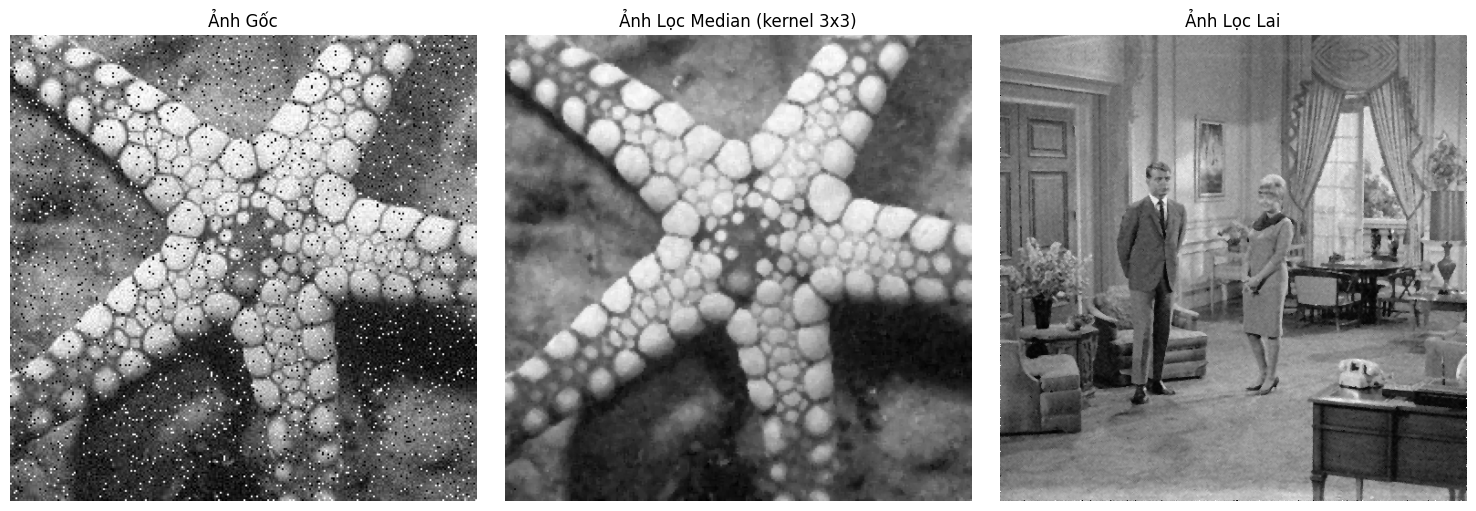

In [80]:
if 'global_image' in globals() and 'filtered_image' in globals():
    # Áp dụng bộ lọc median với cùng kích thước cửa sổ
    median_kernel_size = global_window_size
    median_filtered = median_filter(global_image, median_kernel_size)
    
    # Tạo figure mới để so sánh
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Ảnh Gốc')
    plt.imshow(global_image,cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Ảnh Lọc Median (kernel {median_kernel_size}x{median_kernel_size})')
    plt.imshow(median_filtered.astype(np.uint8),cmap='gray')  # Đảm bảo hiển thị đúng
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Ảnh Lọc Lai')
    plt.imshow(filtered_image.astype(np.uint8), cmap = 'gray')  # Đảm bảo hiển thị đúng
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print('Vui lòng chạy bộ lọc lai trước.')

In [76]:
# Thêm hàm linear_moving_average_filter
def linear_moving_average_filter(image, kernel_size):
    """
    Áp dụng bộ lọc trung bình trượt tuyến tính cho ảnh màu bằng cách xử lý từng kênh riêng biệt.
    
    Tham số:
    - image: Ảnh màu đầu vào (mảng numpy với shape (height, width, 3)).
    - kernel_size: Kích thước cửa sổ vuông (ví dụ: 3 cho cửa sổ 3x3).
    
    Trả về:
    - Ảnh đã lọc trung bình trượt tuyến tính (mảng numpy).
    """
    return ndimage.uniform_filter(image, size= kernel_size)

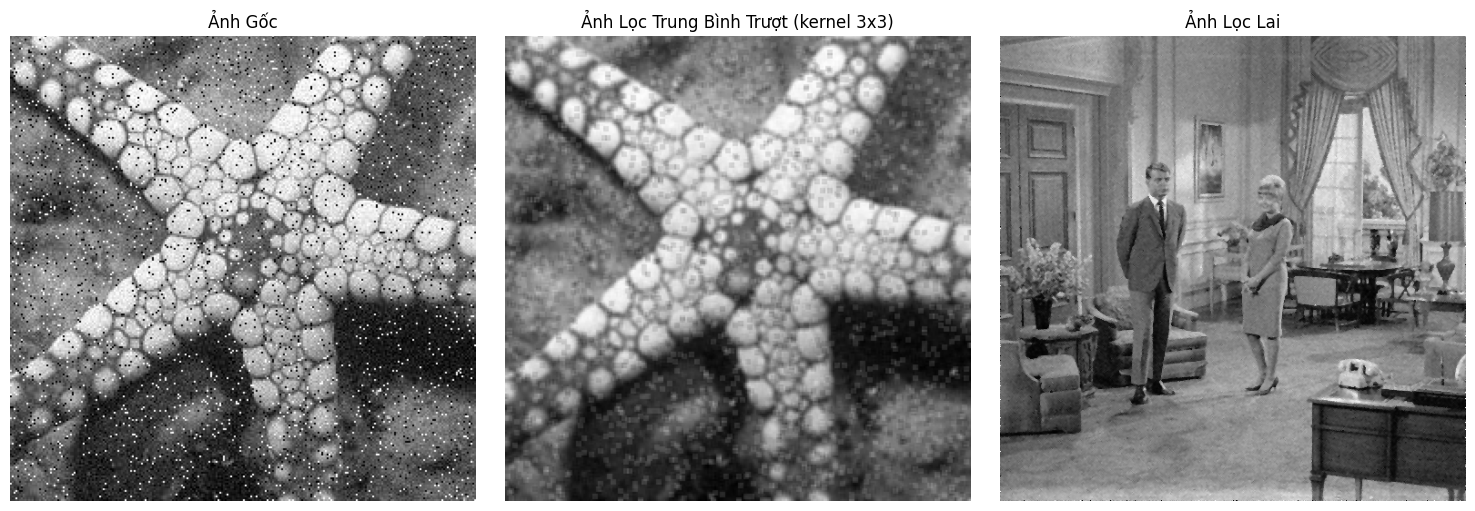

In [81]:
# Cell 10: Hiển thị so sánh các bộ lọc
if 'global_image' in globals() and 'filtered_image' in globals():
    # Áp dụng bộ lọc median và trung bình trượt tuyến tính với cùng kích thước cửa sổ
    kernel_size = global_window_size
    median_filtered = median_filter(global_image, kernel_size)
    linear_filtered = linear_moving_average_filter(global_image, kernel_size)
    
    # Tạo figure mới để so sánh
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Ảnh Gốc')
    plt.imshow(global_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Ảnh Lọc Trung Bình Trượt (kernel {kernel_size}x{kernel_size})')
    plt.imshow(linear_filtered.astype(np.uint8), cmap='gray')  # Đảm bảo hiển thị đúng
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Ảnh Lọc Lai')
    plt.imshow(filtered_image.astype(np.uint8),cmap='gray')  # Đảm bảo hiển thị đúng
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print('Vui lòng chạy bộ lọc lai trước.')

In [84]:
# Đường dẫn đến các thư mục
input_images_folder = "input_images"
noisy_images_folder = "images"

# Đảm bảo các thư mục tồn tại
if not os.path.exists(input_images_folder):
    raise FileNotFoundError(f"Folder '{input_images_folder}' does not exist!")
if not os.path.exists(noisy_images_folder):
    raise FileNotFoundError(f"Folder '{noisy_images_folder}' does not exist!")

# Lấy danh sách các file ảnh gốc
original_image_files = [f for f in os.listdir(input_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Lấy danh sách các file ảnh nhiễu
noisy_image_files = [f for f in os.listdir(noisy_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Danh sách để lưu kết quả MSE
mse_results = []

# Danh sách để lưu kết quả MAE
mae_results = []

# Danh sách để lưu kết quả PSNR
psnr_results = []

# Duyệt qua từng file ảnh gốc
for original_file in original_image_files:
    # Lấy 2 ký tự đầu của tên file ảnh gốc
    original_prefix = os.path.splitext(original_file)[0][:2]
    
    # Tìm các file ảnh nhiễu có 2 ký tự đầu trùng với ảnh gốc
    matching_noisy_files = [f for f in noisy_image_files if f.startswith(original_prefix)]
    
    # Kiểm tra xem có đúng 4 ảnh nhiễu tương ứng không
    if len(matching_noisy_files) != 4:
        print(f"Expected 4 noisy images for {original_file}, but found {len(matching_noisy_files)}. Skipping...")
        continue
    
    # Đọc ảnh gốc
    original_image = Image.open(os.path.join(input_images_folder, original_file))  # Chuyển sang RGB
    original_image = np.array(original_image)  # Shape: (H, W, 3)
    
    # Duyệt qua từng ảnh nhiễu tương ứng
    for noisy_file in matching_noisy_files:
        # Đọc ảnh nhiễu
        noisy_image = Image.open(os.path.join(noisy_images_folder, noisy_file))# Chuyển sang RGB
        noisy_image = np.array(noisy_image)  # Shape: (H, W, 3)
        
        # Áp dụng các bộ lọc (giả định các hàm này đã được định nghĩa)
        median_filtered = median_filter(noisy_image, global_window_size)
        linear_filtered = linear_moving_average_filter(noisy_image, global_window_size)
        filtered_image, _ = hybrid_filter(noisy_image, window_size=global_window_size, threshold=global_threshold, sigma=global_sigma, return_peeled=True)
        
        # Tính MSE cho từng bộ lọc
        mse_median = mean_squared_error(original_image, median_filtered)
        mse_linear = mean_squared_error(original_image, linear_filtered)
        mse_hybrid = mean_squared_error(original_image, filtered_image)

        # Tính MAE cho từng bộ lọc
        mae_median = mean_absolute_error(original_image, median_filtered)
        mae_linear = mean_absolute_error(original_image, linear_filtered)   
        mae_hybrid = mean_absolute_error(original_image, filtered_image)

        psnr_med = psnr(original_image, median_filtered, data_range=255)
        psnr_lin = psnr(original_image, linear_filtered, data_range=255)
        psnr_hyb = psnr(original_image, filtered_image, data_range=255)
        
        # Lưu kết quả MSE với tên file ảnh nhiễu
        mse_results.append([noisy_file, mse_median, mse_linear, mse_hybrid])

        # Lưu kết quả MAE với tên file ảnh nhiễu
        mae_results.append([noisy_file, mae_median, mae_linear, mae_hybrid])

        # Lưu kết quả PSNR với tên file ảnh nhiễu
        psnr_results.append([noisy_file, psnr_med, psnr_lin, psnr_hyb])


# In bảng kết quả
headers = ["Image", "Median", "Linear", "Hybrid"]
print("MSE Results")
print(tabulate(mse_results, headers=headers, tablefmt="fancy_grid"))
print("MAE Results")
print(tabulate(mae_results, headers=headers, tablefmt="fancy_grid"))
print("PSNR Results")
print(tabulate(psnr_results, headers=headers, tablefmt="fancy_grid"))

MSE Results
╒════════════════════════════════╤══════════╤══════════╤══════════╕
│ Image                          │   Median │   Linear │   Hybrid │
╞════════════════════════════════╪══════════╪══════════╪══════════╡
│ 01_gaussian_sp_noise_1.22.jpg  │ 153.244  │ 208.148  │ 128.833  │
├────────────────────────────────┼──────────┼──────────┼──────────┤
│ 01_gaussian_sp_noise_12.21.jpg │ 204.605  │ 490.29   │ 201.692  │
├────────────────────────────────┼──────────┼──────────┼──────────┤
│ 01_gaussian_sp_noise_24.41.jpg │ 322.639  │ 845.344  │ 333.574  │
├────────────────────────────────┼──────────┼──────────┼──────────┤
│ 01_gaussian_sp_noise_6.10.jpg  │ 166.671  │ 324.564  │ 151.04   │
├────────────────────────────────┼──────────┼──────────┼──────────┤
│ 02_gaussian_sp_noise_1.22.jpg  │  50.2911 │  76.0808 │  43.9982 │
├────────────────────────────────┼──────────┼──────────┼──────────┤
│ 02_gaussian_sp_noise_12.21.jpg │  78.1318 │ 318.243  │  92.4759 │
├────────────────────────────────┼──

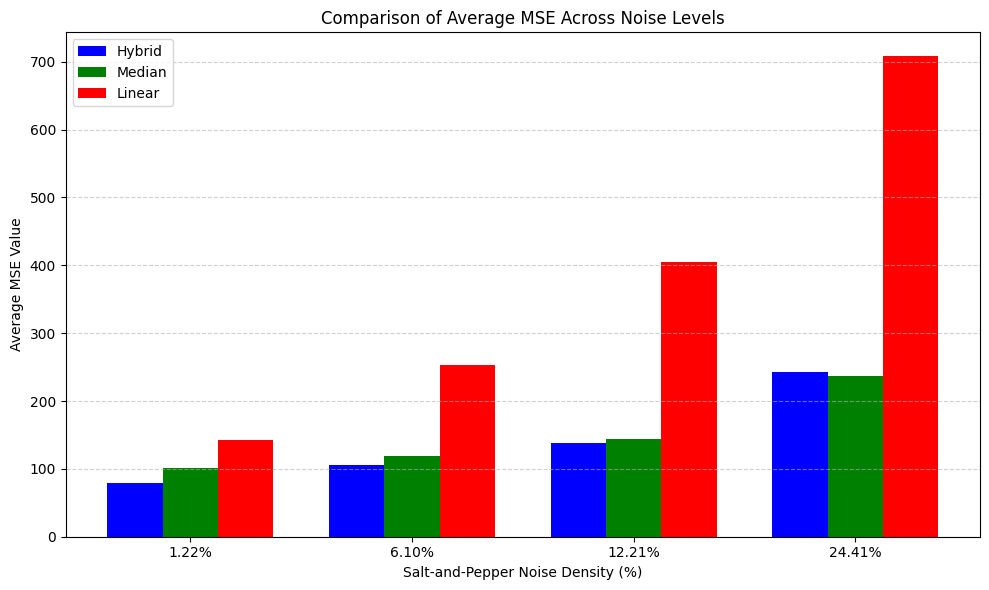

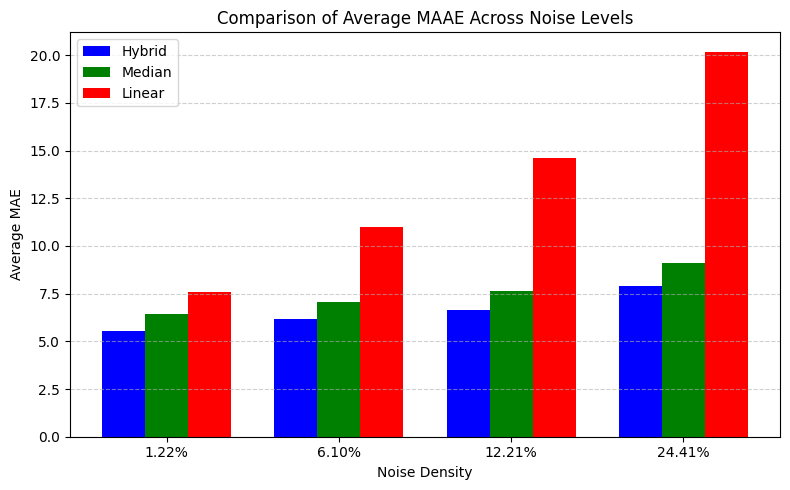

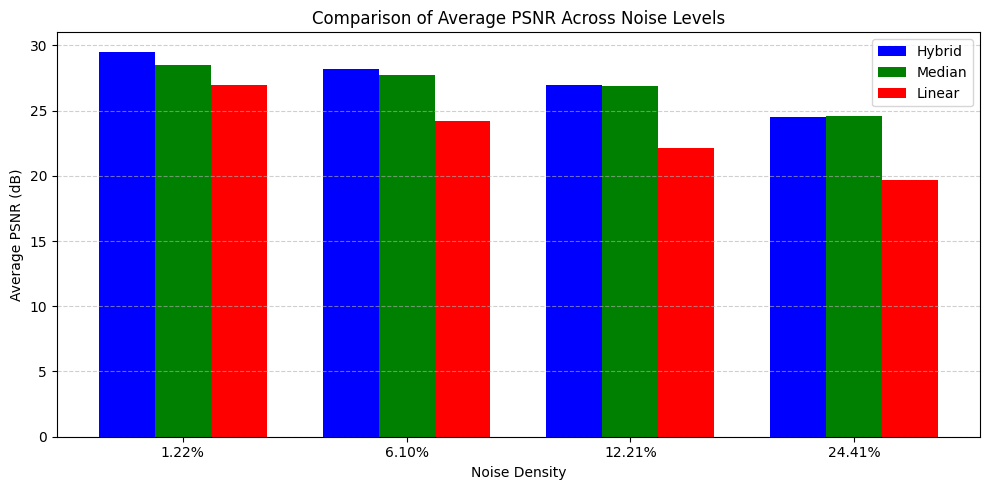

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re


df = pd.DataFrame(mse_results, columns=["Image", "Median", "Linear", "Hybrid"])

df1 = pd.DataFrame(mae_results, columns=["Image", "Median", "Linear", "Hybrid"])
df2 = pd.DataFrame(psnr_results, columns=["Image", "Median", "Linear", "Hybrid"])

# Trích xuất mật độ từ tên file (ví dụ: "01_gaussian_sp_noise_1.22.jpg" → 1.22)
def extract_density(filename):
    match = re.search(r'_(\d+\.\d+)\.jpg$', filename)
    return float(match.group(1)) if match else None

df['Density'] = df['Image'].apply(extract_density)
df1['Density'] = df1['Image'].apply(extract_density)
df2['Density'] = df2['Image'].apply(extract_density)

# Tính MSE trung bình cho mỗi mức mật độ
mean_mse_by_density = df.groupby('Density')[['Median', 'Linear', 'Hybrid']].mean().reset_index()
mean_mae_by_density = df1.groupby('Density')[['Median', 'Linear', 'Hybrid']].mean().reset_index()
mean_psnr_by_density = df2.groupby('Density')[['Median', 'Linear', 'Hybrid']].mean().reset_index()

# Vẽ biểu đồ cột
x = np.arange(len(mean_mse_by_density['Density']))  # các vị trí trên trục x
width = 0.25  # độ rộng cột

plt.figure(figsize=(10, 6))
plt.bar(x - width, mean_mse_by_density['Hybrid'], width, label='Hybrid', color='blue')
plt.bar(x, mean_mse_by_density['Median'], width, label='Median', color='green')
plt.bar(x + width, mean_mse_by_density['Linear'], width, label='Linear', color='red')

# Gán nhãn trục x
plt.xticks(x, [f"{d:.2f}%" for d in mean_mse_by_density['Density']])
plt.xlabel("Salt-and-Pepper Noise Density (%)")
plt.ylabel("Average MSE Value")
plt.title("Comparison of Average MSE Across Noise Levels")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2) MAE
plt.figure(figsize=(8,5))
plt.bar(x - width, mean_mae_by_density['Hybrid'], width, label='Hybrid', color='blue')
plt.bar(x        , mean_mae_by_density['Median'], width, label='Median', color='green')
plt.bar(x + width, mean_mae_by_density['Linear'], width, label='Linear', color='red')
plt.xticks(x, [f"{d:.2f}%" for d in mean_mae_by_density['Density']])
plt.xlabel("Noise Density")
plt.ylabel("Average MAE")
plt.title("Comparison of Average MAAE Across Noise Levels")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 3) PSNR
plt.figure(figsize=(10,5))
plt.bar(x - width, mean_psnr_by_density['Hybrid'], width, label='Hybrid', color='blue')
plt.bar(x        , mean_psnr_by_density['Median'], width, label='Median', color='green')
plt.bar(x + width, mean_psnr_by_density['Linear'], width, label='Linear', color='red')
plt.xticks(x, [f"{d:.2f}%" for d in mean_psnr_by_density['Density']])
plt.xlabel("Noise Density")
plt.ylabel("Average PSNR (dB)")
plt.title("Comparison of Average PSNR Across Noise Levels")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
